In [1]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Trying Eli's nb with no ratio approach

In [2]:
file_path = 'Merged_Ni_lessthan15km.csv'

df = pd.read_csv(file_path, index_col=0)
df.head(3)

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
0,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46661,"(-17.34893, 128.022095)",S0001442,-17.234642,128.032146,12.693593881734987 km
1,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46662,"(-17.31078, 128.023499)",S0002890,-17.234642,128.032146,8.476376684524638 km
2,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46663,"(-17.3526, 128.027695)",S0019720,-17.234642,128.032146,13.063277176872425 km


In [3]:
df.shape

(150625, 19)

In [4]:
df[df['Co'] == df['Co'].max()]

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
15478,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73190,"(-26.107121, 127.696899)",S0019102,-26.061367,127.580028,12.744010894761297 km
15479,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73191,"(-26.107121, 127.696899)",S0224398,-26.061367,127.580028,12.744010894761297 km


In [5]:
df_unique = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'lat', 'long', 
                     'minedex_coords', 'minedex_site',
                    'distance'])

df_unique = df_unique.drop_duplicates()

In [6]:
print(f"Amount of Duplicate rows: {df.shape[0] - df_unique.shape[0]}")

Amount of Duplicate rows: 127392


In [211]:
df_unique.shape

(23233, 12)

### WAMEX data

 ·      Cobalt associated with nickel (and copper) in so-called orthomagmatic (igneous) mafic to ultramafic volcanic (komatiite)-hosted and intrusion-hosted deposits
 
 
 Cobalt is a chemical element with the symbol Co and atomic number 27. Like nickel, cobalt is found in the Earth's crust only in a chemically combined form, save for small deposits found in alloys of natural meteoric iron. The free element, produced by reductive smelting, is a hard, lustrous, silver-gray metal. Wikipedia
Symbol: Co <br>
Electron configuration: [Ar] 3d74s2 <br>
Atomic number: 27 <br>
Atomic mass: 58.933195 u <br>
Melting point: 1,495 °C <br>
Discovered: 1735 <br>
Discoverer: Georg Brandt <br>

### Nickel and Iron

In [7]:
# most common pair in MINEDEX data.
abdundant_minerals = ['Nickel', 'Iron'] #'Sulfur', 'Palladium','Platinum',
critical_mineral = ['Cobalt']

full_to_atomic = {
    "Copper": "Cu",
    "Cobalt": "Co",
    "Nickel": "Ni",
    "Iron": "Fe",
    "Sulfur": "S",
    "Palladium": "Pd",
    "Platinum": "Pt",
    "Gold": "Au",
    "Silver": "Ag"
}


In [8]:
def get_clean_mineral_col(df):
    new_cols = []
    for col in df.columns: 
        if "ppm" in col:
            new_cols.append(col.split('_')[0])
        else:
            new_cols.append(col)
            
    return new_cols

df_unique.columns = get_clean_mineral_col(df_unique)

In [9]:
df_unique.head(2)

,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,wamex_lat,wamex_lon
0,56.0,420.0,9.0,14.0,0.010,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146
5,31.0,195.0,6.0,10.0,0.007,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146


In [10]:
minerals = abdundant_minerals + critical_mineral

minerals_atomic = [full_to_atomic[mineral] for mineral in minerals]
minerals_atomic

['Ni', 'Fe', 'Co']

In [11]:
input_cols = ['wamex_lat', 'wamex_lon'] + minerals_atomic

In [12]:
df_inputs = df_unique[input_cols]
df_inputs.head(2)

,wamex_lat,wamex_lon,Ni,Fe,Co
0,-17.234642,128.032146,56.0,NaN,9.0
5,-17.234642,128.032146,31.0,NaN,6.0


In [13]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
def abs_halve_neg_val(val):
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

def clean_assays(df):
    df = df.applymap(replace_neg9999)
    df = df.applymap(abs_halve_neg_val)
    df = df[df['Ni'] < 300000]
    indexs_0 = df[df.values == 0].index
    df = df.drop(index=indexs_0)
    
    return df

In [14]:
df_minerals = df_inputs.drop(columns=['wamex_lat', 'wamex_lon'])

df_inputs.loc[:, df_minerals.columns] = clean_assays(df_inputs.loc[:,df_minerals.columns])
df_inputs.shape

C:\Users\missc\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\missc\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


(23233, 5)

## `drop_na`

In [15]:
df_inputs = df_inputs.dropna()
df_inputs = df_inputs.drop_duplicates()
df_inputs.shape

(14261, 5)

<AxesSubplot:ylabel='Frequency'>

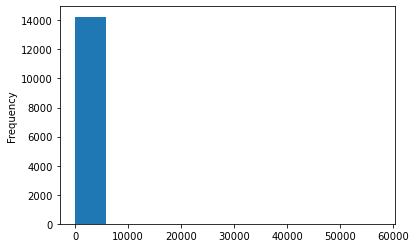

In [13]:
df_inputs['Co'].plot(kind='hist')

<AxesSubplot:>

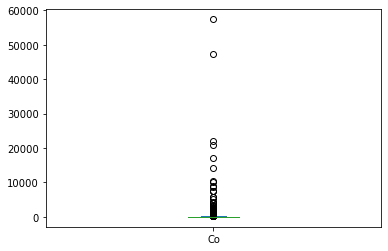

In [14]:
df_inputs['Co'].plot(kind='box')

In [16]:
#remove 2 large outliers 
df_inputs = df_inputs[df_inputs['Co'] < 40000]

<AxesSubplot:>

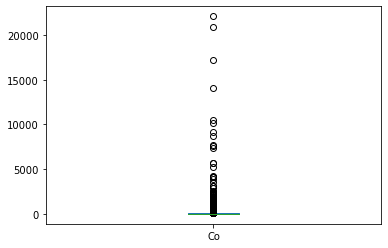

In [16]:
df_inputs['Co'].plot(kind='box')

In [18]:
df_inputs['Co'].describe()

count    14259.000000
mean        75.983857
std        415.441102
min          0.000500
25%         10.000000
50%         25.000000
75%         64.000000
max      22106.000000
Name: Co, dtype: float64

### LARGE Colbalt deposits

In [14]:
df_inputs[df_inputs['Co'] > 10000]

,wamex_lat,wamex_lon,Ni,Fe,Co
3342,-32.094878,121.651236,6450.0,9266.7,10476.0
15446,-26.060096,127.578510,14811.0,5090.0,10122.0
15452,-26.060924,127.579434,32363.0,6700.0,22106.0
15454,-26.062044,127.580593,32734.0,3440.0,20913.0
15472,-26.061490,127.579983,23560.0,8730.0,14119.0
52865,-32.096211,121.651299,10782.0,12120.0,17180.0


### Log Transform

In [17]:
import numpy as np

<AxesSubplot:ylabel='Frequency'>

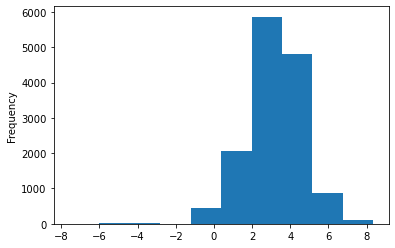

In [18]:
np.log(df_inputs[df_inputs['Co'] < 5000]['Co']).plot(kind='hist')

In [19]:
df_inputs.loc[:, df_minerals.columns] = df_inputs.loc[:,df_minerals.columns].apply(np.log, axis=1)

### Independent Variables

In [23]:
from sklearn.preprocessing import StandardScaler

## Plotting First 100 Observations

<AxesSubplot:>

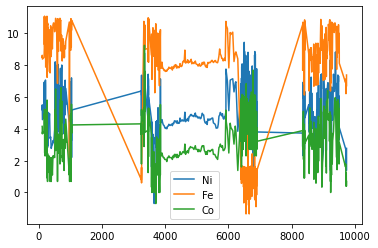

In [24]:
df_inputs[minerals_atomic][:1000].plot()

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### LINEAR REGRESSION

In [20]:
y = df_inputs['Co']
X = df_inputs.drop(columns=['Co'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()

lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

from sklearn.metrics import mean_squared_error

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 0.9857170874346729
Test MSE: 1.0375636890242796


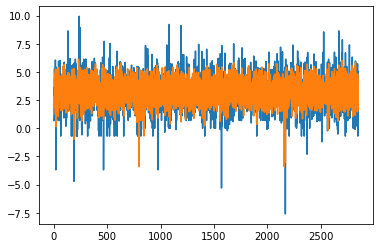

In [29]:
plt.plot(range(0, len(test_preds)), y_test, test_preds)

In [22]:
pd.Series(X_train.columns, lr.coef_).sort_values(ascending=False)

-0.131291    wamex_lon
 0.020056    wamex_lat
 0.559605           Ni
 0.073822           Fe
dtype: object

### Predict from MINDEX data

In [23]:
pred_set = pd.read_csv('./ni_fe_prediction_set.csv')
pred_set.head()

,Unnamed: 0,Nickel,Iron,Latitude,Longitude
0,S0001174,6000.0,79300.0,-33.633382,120.374303
1,S0004371,9900.0,325000.0,-29.125713,122.999515
2,S0004371,9900.0,325000.0,-29.125713,122.999515
3,S0005631,6200.0,108000.0,-33.666733,120.400034
4,S0006586,5500.0,113000.0,-33.592899,120.280502


In [24]:
# save original nickel before transform.
orig_ni = pred_set['Nickel']

In [25]:
pred_set = pred_set.rename(columns={
    "Nickel": "Ni",
    "Iron": "Fe",
    "Latitude": "wamex_lat",
    "Longitude": "wamex_lon",
    "Unnamed: 0": 'site_code'
})

In [26]:
df_minerals = pred_set.drop(columns=['wamex_lat', 'wamex_lon', 'site_code'])

In [27]:
pred_set['Fe'] = pred_set['Fe'].apply(np.log, axis=1)
pred_set['Ni'] = pred_set['Ni'].apply(np.log, axis=1)

In [28]:
pred_X = pred_set[X.columns]

In [29]:
pred_set['Co_pred'] = lr.predict(pred_X)

In [29]:
pred_set.head(2)

,site_code,Ni,Fe,wamex_lat,wamex_lon,Co_pred
0,S0001174,8.699515,11.280993,-33.633382,120.374303,5.493879
1,S0004371,9.200290,12.691580,-29.125713,122.999515,5.623986


#### Invert preds

In [30]:
pred_set['Co_pred'] = np.exp(pred_set['Co_pred'])

In [31]:
pred_set.head()

,site_code,Ni,Fe,wamex_lat,wamex_lon,Co_pred
0,S0001174,8.699515,11.280993,-33.633382,120.374303,243.198764
1,S0004371,9.200290,12.691580,-29.125713,122.999515,276.991202
2,S0004371,9.200290,12.691580,-29.125713,122.999515,276.991202
3,S0005631,8.732305,11.589887,-33.666733,120.400034,252.392213
4,S0006586,8.612503,11.635143,-33.592899,120.280502,240.918340


In [32]:
minedex = pd.read_csv('Transformed_Minedex_data.csv')

In [33]:
pred_sites = pred_set.site_code.to_list()

In [34]:
minedex = minedex[minedex['SiteCode'].isin(pred_sites)]

minedex_co = minedex[minedex['CommodityName'] == 'Cobalt']

minedex_co_uniq = minedex_co[['SiteCode', 'CommodityName']].drop_duplicates().index

In [35]:
minedex_co_uniq = minedex_co[minedex_co.index.isin(minedex_co_uniq)]
minedex_co_uniq

,SiteCode,StartDate,EndDate,Tonnage (Mt),Grade,GradeUnit,CommodityName,ContainedMetal,ContainedMetalUnit,CutOffGrade,TargetCommodityGroup,quantity(tonne),ppm
5649,S0001174,31/12/2017,NaN,11.100000,0.020,percent,Cobalt,2220.00000,tonnes,NaN,NICKEL,2220.00000,200.0
8633,S0004371,01/10/2013,30/12/2018,9.780000,0.100,percent,Cobalt,9780.00000,tonnes,NaN,NICKEL,9780.00000,1000.0
8996,S0005631,31/12/2017,NaN,24.300000,0.030,percent,Cobalt,7290.00000,tonnes,NaN,NICKEL,7290.00000,300.0
9205,S0006586,31/12/2012,NaN,31.400000,0.020,percent,Cobalt,6280.00000,tonnes,NaN,NICKEL,6280.00000,200.0
9271,S0006685,31/12/2012,NaN,63.100000,0.030,percent,Cobalt,18930.00000,tonnes,NaN,NICKEL,18930.00000,300.0
9378,S0016710,24/09/2013,NaN,4.338000,0.084,percent,Cobalt,3643.92000,tonnes,NaN,NICKEL,3643.92000,840.0
9385,S0016719,31/03/2001,NaN,5.390000,0.084,percent,Cobalt,4527.60000,tonnes,NaN,NICKEL,4527.60000,840.0
9559,S0018838,31/12/2017,NaN,81.800000,0.030,percent,Cobalt,24540.00000,tonnes,NaN,NICKEL,24540.00000,300.0
9628,S0018919,26/02/2014,30/12/2018,0.840000,0.090,percent,Cobalt,756.00000,tonnes,NaN,NICKEL,756.00000,900.0
10321,S0020571,31/10/2000,NaN,4.650000,0.069,percent,Cobalt,3208.50000,tonnes,NaN,NICKEL,3208.50000,690.0


In [36]:
cross_ref = pred_set[['site_code', 'Co_pred']].merge(minedex_co_uniq[['SiteCode', 'ppm']],
                                        left_on='site_code', 
                                        right_on='SiteCode')

cross_ref = cross_ref.rename(columns={
    "ppm": "Co_true"
})

cross_ref.drop(columns=['SiteCode'])

,site_code,Co_pred,Co_true
0,S0001174,243.198764,200.0
1,S0004371,276.991202,1000.0
2,S0004371,276.991202,1000.0
3,S0005631,252.392213,300.0
4,S0006586,240.918340,200.0
5,S0006685,260.138942,300.0
6,S0016710,308.303376,840.0
7,S0016719,281.243668,840.0
8,S0018838,253.285503,300.0
9,S0018919,260.959459,900.0


In [37]:
mean_squared_error(cross_ref['Co_true'], cross_ref['Co_pred'])

151145.9924783405

### RANDOM FORREST

In [39]:
rf = RandomForestRegressor(random_state = 42)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

plt.plot(range(0, len(test_preds)), y_test, test_preds)

Train MSE: 0.0575429243997386
Test MSE: 0.4450488480942712


NameError: name 'plt' is not defined

In [40]:
pred_set['RF_Co_pred'] = rf.predict(pred_X)
pred_set['RF_Co_pred'] = np.exp(pred_set['RF_Co_pred'])
pred_set.head()

,site_code,Ni,Fe,wamex_lat,wamex_lon,Co_pred,RF_Co_pred
0,S0001174,8.699515,11.280993,-33.633382,120.374303,243.198764,463.644585
1,S0004371,9.200290,12.691580,-29.125713,122.999515,276.991202,343.017853
2,S0004371,9.200290,12.691580,-29.125713,122.999515,276.991202,343.017853
3,S0005631,8.732305,11.589887,-33.666733,120.400034,252.392213,716.369233
4,S0006586,8.612503,11.635143,-33.592899,120.280502,240.918340,449.477716


In [41]:
cross_ref = pred_set[['site_code', 'Co_pred', 'RF_Co_pred']].merge(minedex_co_uniq[['SiteCode', 'ppm']],
                                        left_on='site_code', 
                                        right_on='SiteCode')

cross_ref = cross_ref.rename(columns={
    "ppm": "Co_true"
})

cross_ref.drop(columns=['SiteCode'])

,site_code,Co_pred,RF_Co_pred,Co_true
0,S0001174,243.198764,463.644585,200.0
1,S0004371,276.991202,343.017853,1000.0
2,S0004371,276.991202,343.017853,1000.0
3,S0005631,252.392213,716.369233,300.0
4,S0006586,240.918340,449.477716,200.0
5,S0006685,260.138942,717.081460,300.0
6,S0016710,308.303376,446.262074,840.0
7,S0016719,281.243668,526.369936,840.0
8,S0018838,253.285503,717.117367,300.0
9,S0018919,260.959459,456.095765,900.0


In [42]:
mean_squared_error(cross_ref['RF_Co_pred'], cross_ref['Co_true'])

143368.53033536676

## SVR

In [ ]:
svr = SVR()
param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [0.1, 1,5,10],'degree' : [1,3,5],'gamma' : ('auto','scale')}
grid_search = GridSearchCV(estimator = svr, param_grid = param, 
                      cv = 3, n_jobs = None, verbose = 2)

svr_grid = grid_search.fit(X_train, y_train)
print(svr_grid.best_params_)

train_preds = svr_grid.predict(X_train)
test_preds = svr_grid.predict(X_test)

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

plt.plot(range(0, len(test_preds)), y_test, test_preds)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] C=0.1, degree=1, gamma=auto, kernel=linear ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, degree=1, gamma=auto, kernel=linear, total=   5.0s
[CV] C=0.1, degree=1, gamma=auto, kernel=linear ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] ....... C=0.1, degree=1, gamma=auto, kernel=linear, total=   4.4s
[CV] C=0.1, degree=1, gamma=auto, kernel=linear ......................
[CV] ....... C=0.1, degree=1, gamma=auto, kernel=linear, total=   4.6s
[CV] C=0.1, degree=1, gamma=auto, kernel=poly ........................
[CV] ......... C=0.1, degree=1, gamma=auto, kernel=poly, total=   3.4s
[CV] C=0.1, degree=1, gamma=auto, kernel=poly ........................
[CV] ......... C=0.1, degree=1, gamma=auto, kernel=poly, total=   3.9s
[CV] C=0.1, degree=1, gamma=auto, kernel=poly ........................
[CV] ......... C=0.1, degree=1, gamma=auto, kernel=poly, total=   4.0s
[CV] C=0.1, degree=1, gamma=auto, kernel=rbf .........................
[CV] .......... C=0.1, degree=1, gamma=auto, kernel=rbf, total=   3.5s
[CV] C=0.1, degree=1, gamma=auto, kernel=rbf .........................
[CV] .......... C=0.1, degree=1, gamma=auto, kernel=rbf, total=   3.4s
[CV] C=0.1, degree=1, gamma=auto, kernel=rbf .........................
[CV] .

In [73]:
pred_set['SVR_Co_pred'] = svr.predict(pred_X)
pred_set['SVR_Co_pred'] = np.exp(pred_set['SVR_Co_pred'])
pred_set.head()

,site_code,Ni,Fe,wamex_lat,wamex_lon,Co_pred,RF_Co_pred,SVR_Co_pred
0,S0001174,8.699515,11.280993,-33.633382,120.374303,243.198764,439.556900,190.988848
1,S0004371,9.200290,12.691580,-29.125713,122.999515,276.991202,205.243465,188.888353
2,S0004371,9.200290,12.691580,-29.125713,122.999515,276.991202,205.243465,188.888353
3,S0005631,8.732305,11.589887,-33.666733,120.400034,252.392213,851.598956,197.334269
4,S0006586,8.612503,11.635143,-33.592899,120.280502,240.918340,369.323614,190.174864


In [74]:
cross_ref = pred_set[['site_code', 'Co_pred', 'RF_Co_pred', 'SVR_Co_pred']].merge(minedex_co_uniq[['SiteCode', 'ppm']],
                                        left_on='site_code', 
                                        right_on='SiteCode')

cross_ref = cross_ref.rename(columns={
    "ppm": "Co_true"
})

cross_ref.drop(columns=['SiteCode'])

,site_code,Co_pred,RF_Co_pred,SVR_Co_pred,Co_true
0,S0001174,243.198764,439.556900,190.988848,200.0
1,S0004371,276.991202,205.243465,188.888353,1000.0
2,S0004371,276.991202,205.243465,188.888353,1000.0
3,S0005631,252.392213,851.598956,197.334269,300.0
4,S0006586,240.918340,369.323614,190.174864,200.0
5,S0006685,260.138942,851.598956,202.781400,300.0
6,S0016710,308.303376,438.290424,213.269802,840.0
7,S0016719,281.243668,312.253258,191.889861,840.0
8,S0018838,253.285503,843.140466,197.808680,300.0
9,S0018919,260.959459,328.542155,179.163509,900.0


In [ ]:
mean_squared_error(cross_ref['SVR_Co_pred'], cross_ref['Co_true'])